In [22]:
import pickle

with open('./data2.pickle','rb') as fr:
    data = pickle.load(fr)

In [23]:
def distortion(img):
    img[img==255]=12
    img  +=1
    img =cv2.remap(img,data['map_x'],data['map_y'],interpolation=cv2.INTER_NEAREST)
    return img

[  0   2   4   5   6   7   8  11 255]
[  0   2   4   5   6   7   8  11 255]
[ 0  1  3  5  6  7  8  9 12 13]


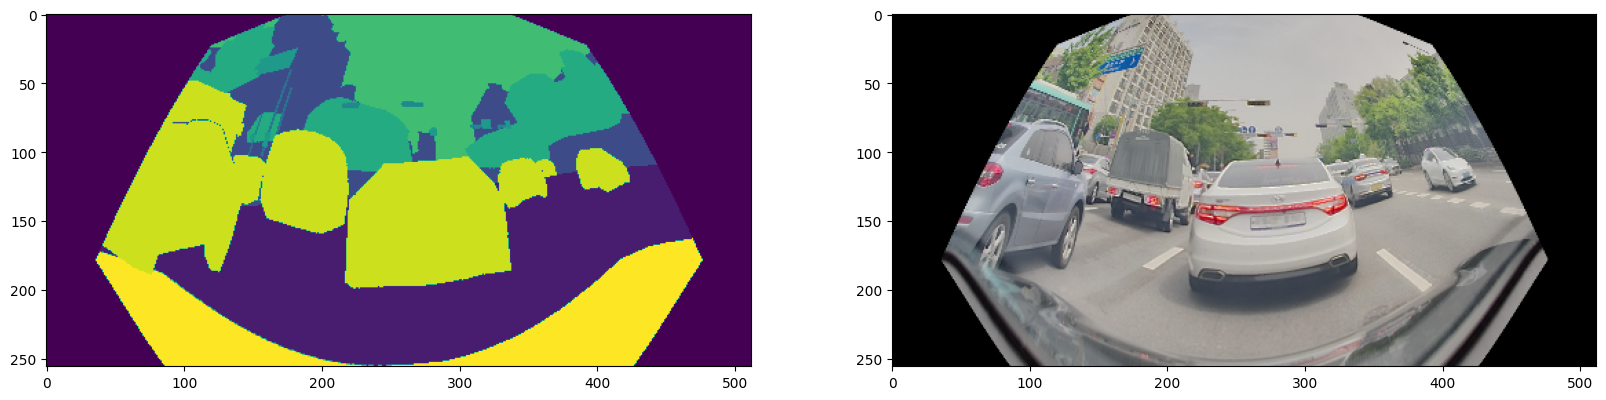

In [26]:
from PIL import Image
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms
from albumentations.core.transforms_interface import ImageOnlyTransform,DualTransform
from tqdm import tqdm
import albumentations as A
from albumentations.pytorch import ToTensorV2
import cv2
import numpy as np
class BarrelDistortion(DualTransform):

    def __init__(
        self,
        always_apply=False,
        p=1
 ):

        super(BarrelDistortion, self).__init__(always_apply, p)

    def apply(self, img, **params):
        return distortion(img)

image = cv2.imread('./train_source_image/TRAIN_SOURCE_0011.png')
ori_image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
ori_mask = cv2.imread('./train_source_gt/TRAIN_SOURCE_0011.png', cv2.IMREAD_GRAYSCALE)
transform = A.Compose([
    # A.OpticalDistortion(distort_limit=0.8,shift_limit=1,p=1),
#    A.fourier_domain_adaptation(img = image,target_img = target_imaeg, beta =0.3),
    BarrelDistortion(),
    A.Resize(width=512, height=256),
    # A.RandomCrop(width=224,height=224,p=0.3)
    # A.Normalize(mean=ADE_MEAN, std=ADE_STD)
])
print(np.unique(ori_mask))
print(np.unique(ori_mask))
augmented = transform(image=ori_image, mask=ori_mask)
# ori_mask[ori_mask == 255] = 30
print(np.unique(augmented['mask']))
plt.figure(figsize=(20,30))
plt.subplot(1,2,1)
plt.imshow(augmented['mask'])
plt.subplot(1,2,2)
plt.imshow(augmented['image'])
# [ 0  1  2  3  6  7  8 11 12] 기존 ->  0  1  2  3  4  5  6  7  8  9 10 11 12

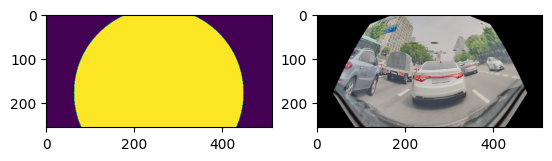

In [27]:
from scipy.optimize import leastsq
import numpy as np
import cv2
import matplotlib.pyplot as plt

#image = augmented['image'].permute(1,2,0).numpy()
# Function to calculate the residuals for least squares circle fit
def calculate_residuals(c, x, y):
    xi = c[0]
    yi = c[1]
    ri = c[2]
    return ((x-xi)**2 + (y-yi)**2 - ri**2)
def make_mask_circle(image):
    # Initialize lists to store the coordinates of the first non-black pixels from left and right for each row
    x_coords = []
    y_coords = []

    non_vignetting_threshold = 20
    inner_circle_margin = 10
    # image_path = "./train_target_image/TRAIN_TARGET_0000.png"
    # img = cv2.imread("./train_target_image/TRAIN_TARGET_0000.png")
    
    img_gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    # Scan each row of the image
    for i in range(img_gray.shape[0]):

        # Scan from the left
        for j in range(img_gray.shape[1]):
            if np.any(img_gray[i,j] > non_vignetting_threshold):
                x_coords.append(j)
                y_coords.append(i)
                break

        # Scan from the right
        for j in range(img_gray.shape[1]-1, -1, -1):
            if np.any(img_gray[i,j] > non_vignetting_threshold):
                x_coords.append(j)
                y_coords.append(i)
                break

    # Convert the lists to numpy arrays
    x = np.array(x_coords)
    y = np.array(y_coords)

    # Initial guess for circle parameters (center at middle of image, radius half the image width)
    c0 = [img_gray.shape[1]/2, img_gray.shape[0]/2, img_gray.shape[1]/4]

    # Perform least squares circle fit
    c, _ = leastsq(calculate_residuals, c0, args=(x, y))

    img_color = image.copy()
    # Draw the circle on the original image
    cv2.circle(img_color, (int(c[0]), int(c[1])), int(c[2])-10, (0, 255, 0), 2);

    # Fill in the inside of the circle
    mask_valid = np.zeros((image.shape[0], image.shape[1])).astype(np.uint8)
    image2 = cv2.circle(mask_valid, (int(c[0]), int(c[1])), int(c[2])-inner_circle_margin, 1, -1);
    return image2
mask_valid = make_mask_circle(augmented['image'])
plt.subplot(1,2,1)
plt.imshow(mask_valid)
plt.subplot(1,2,2)
plt.imshow(augmented['image'])

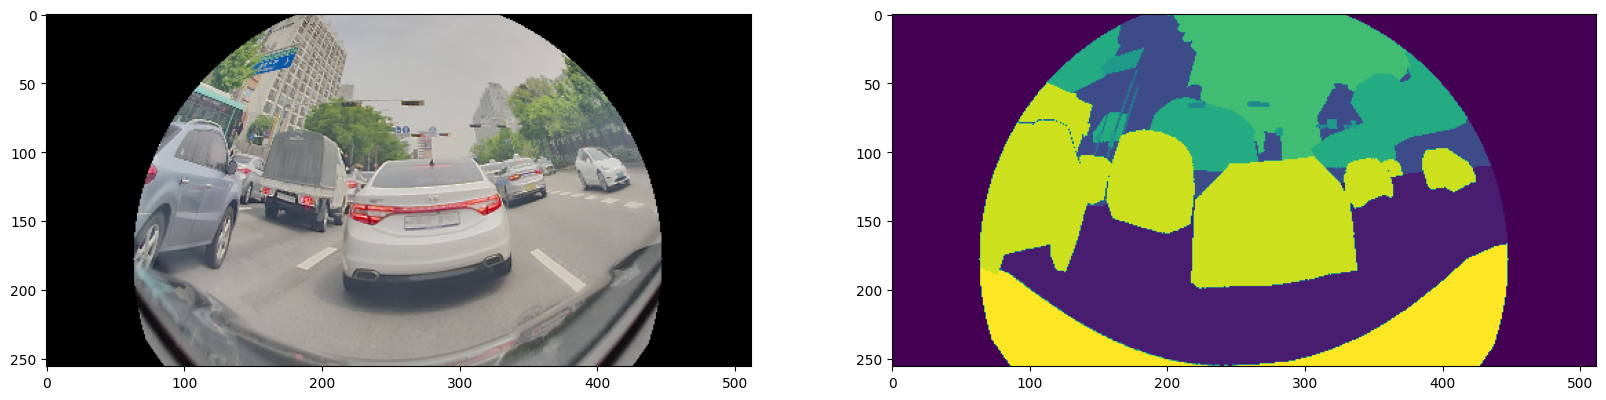

In [28]:
# mask_valid = make_mask_circle(image)
test = cv2.copyTo(augmented['image'],mask_valid)
test2 = cv2.copyTo(augmented['mask'],mask_valid)
plt.figure(figsize=(20,15))
plt.subplot(1,2,1)
plt.imshow(test)
plt.subplot(1,2,2)
plt.imshow(test2)

In [ ]:
from glob import glob

train_source_path=  glob('./train_source_image/*.png')
train_mask_path = glob('./train_source_gt/*.png')

# print(train_mask_path[0].split("\\")[-1])
import os
# if not os.path.exists('./train_source_image2fish') and not os.path.exists('./train_source_gt2fish'):
#     os.mkdir('./train_source_image2fish')
#     os.mkdir('./train_source_gt2fish')
for i in tqdm(range(len(train_source_path))):
    source = cv2.imread(train_source_path[i], cv2.COLOR_BGR2RGB)
    mask = cv2.imread(train_mask_path[i], cv2.COLOR_BGR2GRAY)
    mask = distortion(mask)
    source = distortion(source)
    mask_valid = make_mask_circle(source)
    source2fish = cv2.copyTo(source,mask_valid)
    mask2fish = cv2.copyTo(mask,mask_valid)
    image_name = train_source_path[i].split('/')[-1]
    mask_name = train_mask_path[i].split('/')[-1]
    cv2.imwrite(('./train_source_image2fish/'+image_name),source2fish)
    path = './train_source_image2fish/'+image_name
    cv2.imwrite(('./train_source_gt2fish/'+mask_name),mask2fish)


  0%|          | 0/2194 [00:00<?, ?it/s]

100%|██████████| 2194/2194 [2:14:06<00:00,  3.67s/it]  


In [ ]:
from glob import glob
import cv2
import matplotlib.pyplot as plt
import numpy as np

mask_path = "./train_source_gt2fish/TRAIN_SOURCE_0005.png"
mask = cv2.imread(mask_path, cv2.IMREAD_GRAYSCALE)

print(np.unique(mask))


mask_path = "./train_source_gt/TRAIN_SOURCE_0005.png"
mask = cv2.imread(mask_path, cv2.IMREAD_GRAYSCALE)

print(np.unique(mask))

[ 0  1  2  3  4  5  6  7  8  9 10 12 13]
[  0   1   2   3   4   5   6   7   8   9  11 255]


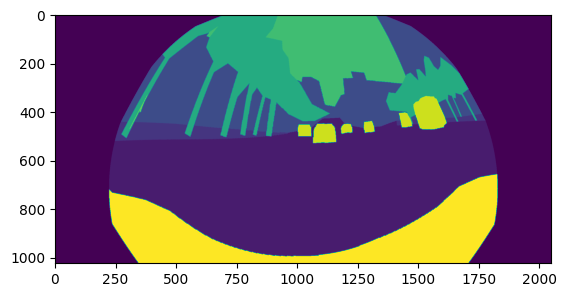

In [13]:
plt.imshow(mask)